# Predicting Clothing Item Ratings For a Women's Clothing Company
---
# Introduction
[This kaggle dataset](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) includes 23486 rows of reviews from a women's e-commerce clothing company which is not identified. Each row represents a single reviewed item, and there are 10 columns of additional information about the garment and customer satisfaction.

In this project, we are investigating the roles of different factors in predicting customers' ratings of clothing items using linear regression. Most information in this dataset is self-reported, so some values may have dubious accuracy, however we can use this as a starting point for predicting item ratings.

I hypothesize that items like pants may need to be tried on to judge fit, and will be negatively correlated with ratings. As well, I predict that recommendation status will be positively correlated with ratings, as people who recommend and item will likely rate it highly.

Being able to use customer or item attributes to predict rating values can have a huge impact on sales, as it is well known that customers take reviews into account when shopping online (e.g. [Influence of consumer reviews on online purchasing decisions in older and younger adults](https://www.sciencedirect.com/science/article/pii/S0167923618300861)). This information could inform types of items carried, what products are highly advertised and to whom, as well as other business decisions.

Many of the variables included in this dataset consist of strings or binary integers. String values make linear regression difficult because they require the variables to be numerically encoded. As well, binary variables limit the amount of information included in the values, and make visualizations such as scatterplots impossible.

---
# Importing & Viewing the Data

In [83]:
# importing libraries
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from math import sqrt
from sklearn.model_selection import cross_val_score

In [48]:
# importing data
review_data = pd.read_csv('/Users/kailuker/Documents/Data Analytics/Project3/Womens Clothing E-commerce Reviews.csv')

In [49]:
# viewing the first few rows of the data to get a feel for the data structure & values
review_data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Column Label Glossary

### Unnamed: 0
- Index number

### Clothing ID
- Unique identifier for the specific item

### Age
- Reviewer's self-reported age

### Title
- Title of the review

### Review Text
- Body of the review

### Rating
- Integer rating from 1-5

### Recommended IND
- Binary variable
- Represents whether (1) or not (0) the customer would recommend the item to others

### Positive Feedback Count
- Number of customers that found the review helpful

### Division Name
- Highest-level item category

### Department Name
- Item department name

### Class Name
- Specific item category name

---
# Exploratory Analysis & Data Cleaning

In [50]:
# removing spaces & capital letters from column names so that they are easier to work with
review_data.columns=['unnamed:0', 'clothing_id', 'age', 'title', 'review_text', 'rating', 'recommended_ind', 'positive_feedback_count', 'division_name', 'department_name', 'class_name']

## Deciding what clothing category type to use
- The category should not be too broad or too specific
- The category should not have too many categories
- department_name fits these criteria

In [51]:
# viewing the unique values within division_name
review_data['division_name'].unique()

array(['Initmates', 'General', 'General Petite', nan], dtype=object)

In [52]:
# viewing the unique values within department_name
review_data['department_name'].unique()

array(['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend', nan],
      dtype=object)

In [53]:
# viewing the unique values within class_name
review_data['class_name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', nan, 'Chemises'], dtype=object)

## Investigating NaN values
- Do not want to skew the data by removing missing values that have a specific pattern
- Because most NaNs are in columns that I will not be analyzing, I will only compare the shapes of the department_name distribution with & without missing values
- The department_name column is not significantly changed when missing values are dropped, so I am comfortable dropping NaN values
- This consistency is also shown visually in the graphs below

### Counting the Number of Missing Values

In [54]:
# counting missing values in each category
review_data.isna().sum()

unnamed:0                     0
clothing_id                   0
age                           0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

In [55]:
# making a new variable to store data without missing values
no_miss_reviews = review_data.dropna()

### Comparing the Data With & Without Missing Values

In [56]:
# conducting a 2-sample Kolmogorov-Smirnov test to see if shapes of the data with & without missing values is significantly different
# the shapes of the samples are not significantly different even though we have dropped missing values
ks_2samp(review_data['department_name'].value_counts(), no_miss_reviews['department_name'].value_counts())

KstestResult(statistic=0.16666666666666666, pvalue=0.9999999999999998)

<AxesSubplot:title={'center':'Item Type Distribution Including Missing Values'}, xlabel='department_name', ylabel='Count'>

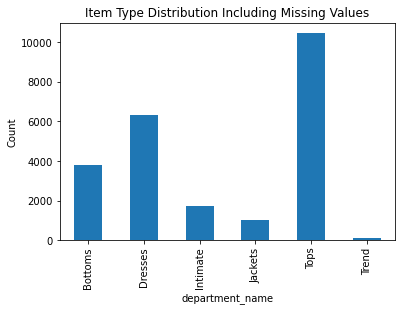

In [57]:
# department_name distribution including missing values
review_data.groupby('department_name').size().plot(kind='bar', title='Item Type Distribution Including Missing Values', ylabel='Count')

<AxesSubplot:title={'center':'Item Type Distribution Excluding Missing Values'}, xlabel='department_name', ylabel='Count'>

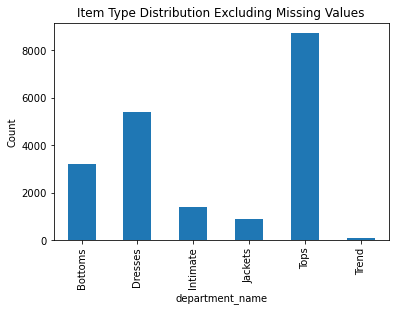

In [58]:
# department_name distribution without missing values
no_miss_reviews.groupby('department_name').size().plot(kind='bar',title='Item Type Distribution Excluding Missing Values', ylabel='Count')

## Getting Descriptive Statistics of Columns

In [59]:
# make department_name into several numeric columns so that it can be included in the linear regression
department_name_encoded = pd.get_dummies(no_miss_reviews['department_name'])

In [60]:
# adding the encoded department name columns to the rest of the data for the regression
regression_data = pd.concat([no_miss_reviews, department_name_encoded], axis=1)

In [61]:
# dropping irrelevant data
regression_data.drop(columns=['unnamed:0', 'clothing_id', 'title', 'review_text', 'division_name', 'department_name', 'class_name'], inplace=True)

In [62]:
# getting descriptive statistics of columns of interest
regression_data.describe()

,age,rating,recommended_ind,positive_feedback_count,Bottoms,Dresses,Intimate,Jackets,Tops,Trend
count,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000
mean,43.260808,4.183145,0.818177,2.652477,0.161937,0.273167,0.071610,0.044706,0.443139,0.005442
std,12.258122,1.112224,0.385708,5.834285,0.368402,0.445597,0.257848,0.206662,0.496769,0.073571
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,5.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,99.000000,5.000000,1.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Things to Note:
- With missing values removed, there are now 19662 rows
- Average rating value is 4.18, so we can conclude ratings are positively skewed
- Age has a high standard deviation, meaning age may be less reliable as a predictor variable
- Many of these columns are binary (1 or 0) and so statistics like min & max aren't useful

## Exploratory Analysis
### Ratings Distribution
- This confirms that the ratings are positively skewed
- Because of the large amount of data, this is not a cause for concern, as there are many lower ratings as well

<AxesSubplot:title={'center':'Ratings Distribution'}, xlabel='rating', ylabel='Count'>

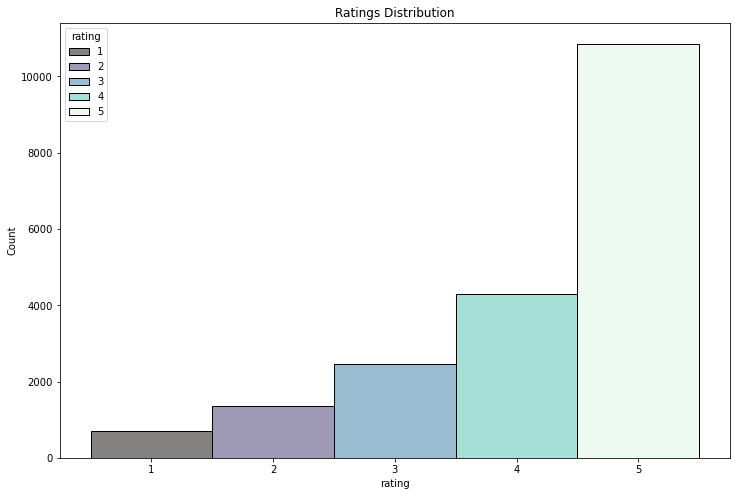

In [63]:
# set size of plot
plt.figure(figsize=(12, 8))
# set title of plot
plt.title(label='Ratings Distribution')
# create rating distribution
sns.histplot(data=regression_data, x='rating', hue='rating', palette='mako', discrete=True)

### Age Distribution
- There is a large range of ages
- Most customers are 30 to 40, which is in line with the mean age
- There are outliers who are above 80 years old, contributing to the high standard deviation
- Because of an extreme number of customers at certain ages, we added a KDE to get a better idea of the population's age distribution
- We should keep an eye on age in the main analysis, as we will likely want to exclude it

<AxesSubplot:title={'center':'Age Distribution'}, xlabel='age', ylabel='Count'>

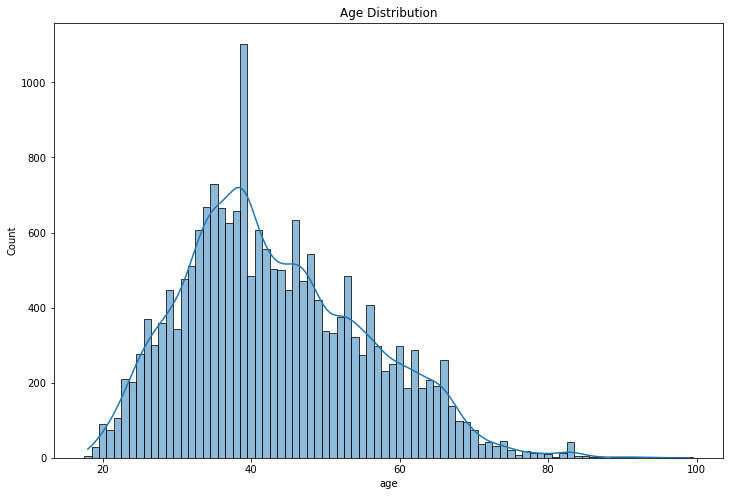

In [64]:
# set size of plot
plt.figure(figsize=(12, 8))
# set title of plot
plt.title(label='Age Distribution')
# create age distribution
sns.histplot(data=regression_data, x='age', kde=True, palette='mako', discrete=True)

## Creating a Correlation Heatmap
- Finding correlations between all variables included in the linear regression
- The only variables that appear to be highly correlated are recommended_ind & rating at 0.79
- This may be concerning as recommended_ind could be the only predictor of rating

<AxesSubplot:title={'center':'Variable Correlation Heatmap'}>

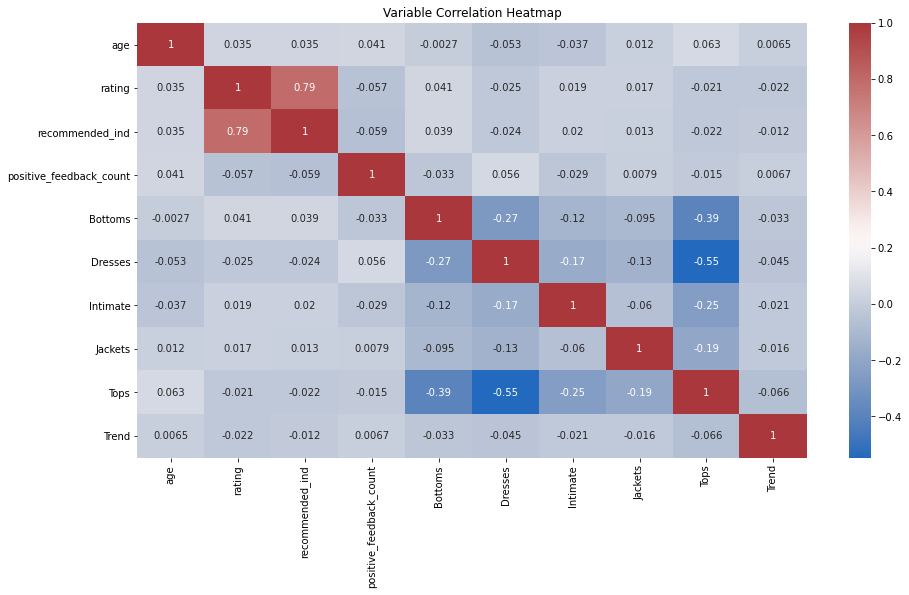

In [65]:
# set size of plot
plt.figure(figsize=(15,8))
# set title of plot
plt.title(label='Variable Correlation Heatmap')
# create heatmap
sns.heatmap(regression_data.corr(), annot=True, cmap='vlag')

---
# Main Analysis
- The main analysis for trying to predict customer ratings of clothing items
- Using a linear regression model to investigate how each independent variable contributes to the dependent variable
- Using regression modelling to test & confirm the model
- Because all of the variables in the analysis are discrete, there is no way to clearly visualize the relationships in charts

In [66]:
# defining dependent & independent variables & adding the constant
# dependent variable is rating
dep_var = regression_data['rating']
#independent variables are all columns except rating
ind_vars = regression_data.drop('rating', axis=1)
# constant = 1
ind_vars['constant'] = 1

## Linear Regression Attempt 1
- R-squared is moderate, so we will try to improve the model
- Note that the coefficient of recommended_ind is much higher than any other independent variable, as we expected due to their high level of correlation

In [68]:
# running the linear regression
lin_reg = sm.OLS(dep_var, ind_vars)
reg_results = lin_reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     4175.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:41:36   Log-Likelihood:                -20228.
No. Observations:               19662   AIC:                         4.047e+04
Df Residuals:                   19653   BIC:                         4.054e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                       

## Linear Regression Attempt 2
- Removing age, positive_feedback_count, & Trend variables as they have low coefficients & high p-values
- This confirms what we thought, that age is a poor predictor of rating
- Removing these variables does not improve the overall model

In [69]:
# removing positive_feedback_count, age, & Trend
ind_vars2 = ind_vars.drop(columns=['age', 'positive_feedback_count', 'Trend'])

In [70]:
# running the linear regression
lin_reg2 = sm.OLS(dep_var, ind_vars2)
reg_results2 = lin_reg2.fit()
print(reg_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     5564.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:41:38   Log-Likelihood:                -20231.
No. Observations:               19662   AIC:                         4.048e+04
Df Residuals:                   19655   BIC:                         4.053e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
recommended_ind     2.2849      0.013    1

## Linear Regression Attempt 3: Only Rating & Recommendation
- recommended_ind appears to be accounting for most of the predictive power of the model
- Running a linear regression only between rating & recommended_ind to further investigate this relationship
- Removing all independent variables other than recommended_ind did not change the value of r-squared
- We can conclude that the relationship between rating & recommendation status is very strong, & that no other independent variables are substantially related to rating

In [71]:
# removing all independent variables other than recommended_ind
ind_vars3 = ind_vars2.drop(columns=['Bottoms', 'Dresses', 'Intimate', 'Jackets', 'Tops'])

In [72]:
# running the linear regression
lin_reg3 = sm.OLS(dep_var, ind_vars3)
reg_results3 = lin_reg3.fit()
print(reg_results3.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 3.334e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:41:40   Log-Likelihood:                -20240.
No. Observations:               19662   AIC:                         4.048e+04
Df Residuals:                   19660   BIC:                         4.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
recommended_ind     2.2871      0.013    1

## Testing the Final Model

In [73]:
# defining independent variables
X = ind_vars3
# defining dependent variable
y = dep_var

In [76]:
# creating test & train sets for independent & dependent variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=175)

In [77]:
# viewing the size & shape of the sets that were created
# each train set has 15729 rows, & each test set has 3933 rows
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15729, 2)
(3933, 2)
(15729,)
(3933,)


In [78]:
# fitting the linear regression
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [79]:
# getting salary values when test values are entered
y_pred = lr.predict(X_test)

## Evaluating the Model
- On average, this model's prediction of ratings is off by 0.67
- The model has moderate predictive power consistent with the linear regression results

In [80]:
# calculating RMSE
print('RMSE:',np.round(sqrt(mt.mean_squared_error(y_test,y_pred)),2))

# calculating R-Square; closer to 1 is better
print('R-Squared:',np.round(mt.r2_score(y_test,y_pred),2))

RMSE: 0.67
R-Squared: 0.62


#### Cross Validation
- Checking the model again by increasing the amount of test data
- The average cross-validation score is close to the model's R-squared value, reinforcing the medium prediction power of the model

In [81]:
# finding the cross-validation score using 10 folds
print(np.mean(cross_val_score(lr, X_train, y_train, cv=10)))

0.6315915069824405


## Relationship Between Recommendation Status & Rating
- Because of the results of Linear Regression 3, we should further investigate the relationship between recommendation status & rating
- The first chart is a bar graph showing the average rating for items that were & were not recommended
- It is clear that the average rating of those who did recommend the item is much higher than those who did not
- The second chart is a histogram showing the proportion of customers who chose each rating number & their recommendation status
- It is evident that items that were more highly rated were also recommended more often

<AxesSubplot:title={'center':'Mean Rating by Recommendation Status'}, xlabel='recommended_ind', ylabel='rating'>

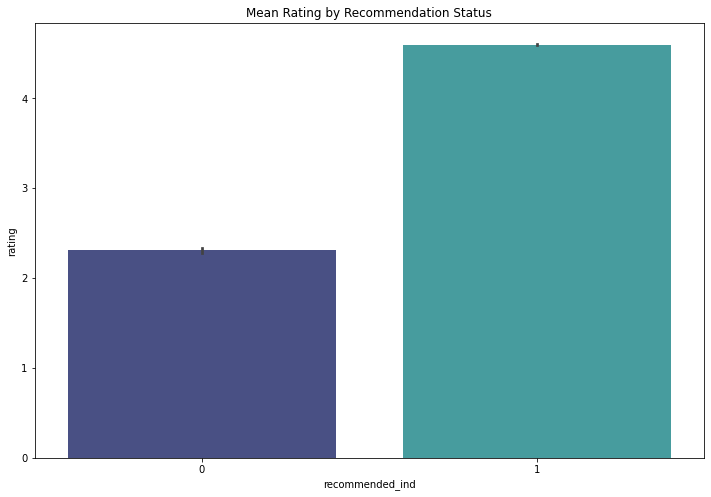

In [25]:
# set size for plot
plt.figure(figsize=(12, 8))
# set title of plot
plt.title(label='Mean Rating by Recommendation Status')
# comparing rating means of items that were or were not recommended
sns.barplot(data=regression_data, x='recommended_ind', y='rating', palette='mako')

<AxesSubplot:title={'center':'Recommendation Status Totals by Rating'}, xlabel='rating', ylabel='count'>

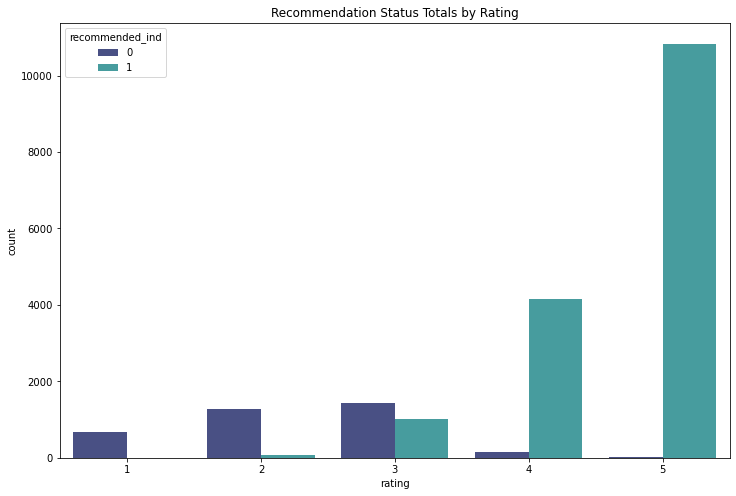

In [26]:
# set size for plot
plt.figure(figsize=(12, 8))
# set title of plot
plt.title(label='Recommendation Status Totals by Rating')
# distribution of ratings with colour indicating recommendation status
sns.countplot(data=regression_data, x='rating', hue='recommended_ind', palette='mako', dodge=True)

---
# Conclusion
With the information provided by this dataset, we are able to predict customer ratings with moderate accuracy, however, almost all of that prediction power comes from a single variable. Though recommendation status is associated with ratings, it is essentially useless as a predictor. Similar to rating, it is a customer provided value rather than an attribute of the item or factor that can be controlled by the company. This gives the company no information on how to improve website ratings, or to improve their catalogue.

---
# Recommendations
- Include more information in the reviews that could better predict ratings (possibly rating of fit and size, selections of why they liked and did not like the item, etc.)
- Include either rating or recommendation column; they are highly correlated so both are not necessary
- Once changes have been implemented and more data is collected, use factors that correlate with rating to optimize products & push those which correlate with higher ratings
- By predicting which items will be rated higher, it is possible to influence consumer behaviour